## Guided Self-Study

Students are encouraged to work through this worksheet at home. Alternatively, they can complete it during the Python Focus Session, where the Host will be available to provide guidance and support.

## Financial Set-up:

You have access to a cleaned dataset of daily returns for Euro Stoxx 50 stocks. Your task is to focus on the return series of Adidas.

Start by visualizing the time series to get a sense of the data—look for obvious errors and try to understand its general shape. Does it look roughly Gaussian? Are there jumps? Signs of volatility clustering? Anything unusual?

Next, based on the observed return series, you'll estimate the conditional variance of returns. While we’re not applying a formal filter here, you can think of this as “filtering out” the variance.

To do this, assume the return series follows an ARMA-GARCH process. In this case, we use an AR(2)-GARCH(1,1) model.

Write down the likelihood function for this model and implement the estimation algorithm.

Note: The exact ARMA-GARCH order isn’t critical. Feel free to experiment with other specifications and compare the results.

### Get daily return data

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch import arch_model
import matplotlib as plt
import scipy.optimize as sco

In [8]:
df = pd.read_csv("r_ES50_d_cleaned_realized.csv", index_col="Date")

In [9]:
df

,ADS.DE,AI.PA,ALV.DE,ASML.AS,CS.PA,BBVA.MC,SAN.MC,BAS.DE,BAYN.DE,BMW.DE,...,SU.PA,SIE.DE,TEF.MC,FP.PA,URW.AS,UNA.AS,DG.PA,VIV.PA,VOW.DE,1/N
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.023996,-0.009332,-0.004736,-0.100229,-0.015385,-0.022708,-0.024598,-0.038939,-0.026907,-0.019987,...,-0.042903,-0.034424,-0.047851,-0.025479,-0.000945,0.021525,0.022467,-0.024392,-0.037946,-0.022821
2000-01-06,0.041964,0.069408,0.040316,-0.072511,-0.007782,0.006279,0.000000,0.003755,0.003403,-0.003249,...,0.049442,-0.012306,0.000874,-0.029461,0.029561,0.036187,0.032790,-0.011798,-0.004413,0.006099
2000-01-07,-0.013793,-0.012318,0.027432,0.072005,0.030772,0.006240,0.043328,0.040197,0.040830,-0.001810,...,0.018089,0.039441,0.000873,0.004971,-0.006212,0.014364,0.031750,0.008088,0.028438,0.023823
2000-01-10,0.015025,-0.035451,0.005750,0.069533,0.000000,-0.016227,-0.008872,0.004390,0.035670,0.039081,...,-0.016786,0.057803,0.029700,0.000826,0.010789,-0.011506,-0.042558,0.086030,0.002800,0.009664
2000-01-11,-0.009347,-0.009217,-0.009157,0.012224,-0.022990,-0.020279,-0.034456,-0.045421,-0.030031,-0.003490,...,-0.039170,0.006872,0.000849,0.007404,0.004556,-0.012549,0.042558,0.018587,0.015536,-0.004634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,0.009711,0.005137,0.015274,0.000777,0.008762,0.012781,0.024750,0.001007,-0.029875,0.015893,...,0.005816,0.008457,0.023065,0.007984,0.021723,-0.001435,0.011280,0.008270,0.018981,0.008056
2020-06-26,-0.021232,-0.005930,-0.015387,0.006192,-0.002372,-0.024058,-0.031093,-0.020328,-0.016924,-0.023218,...,0.007634,-0.002746,-0.020212,-0.001848,-0.052789,0.006543,-0.008571,-0.003039,-0.009094,-0.007704
2020-06-29,-0.006891,0.011041,0.012395,-0.005571,0.005061,0.027633,0.039511,0.029043,0.001646,0.016714,...,0.013272,0.018099,0.024855,0.002463,0.011663,-0.025595,0.017311,0.008658,0.010486,0.012619


In [10]:
r_t = df["ADS.DE"] #adidas returns

<Axes: xlabel='Date'>

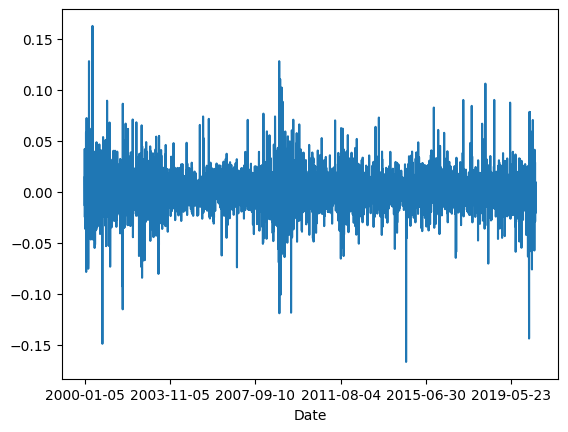

In [11]:
r_t.plot()

## Model

Research out what the log likelihood for a Gaussian AR(2)-GARCH(1,1) model looks like. Give AI a chance here; this is also research :-).

When I asked GPT, I got a perfectly correct answer. 

Moreover, GPT revealed: "**New skill: Understanding vs. Deriving**

In a world with tools like this, the teaching goal shifts from “Can you derive this by hand?” to “Do you understand what this expression means, and can you use it wisely?”

Just like we don’t teach students to take square roots by hand anymore — but we still teach what a square root is."




## Handmade MLE

In [12]:

# MLE estimation of AR(2)-GARCH(1, 1) model
# -------------------------------------------------

def garch_1_1_variance(:
    
    return 
    

def Neg_loglikelihood_ar2_Garch11():
    
    
    return 

SyntaxError: invalid syntax (1565990096.py, line 4)

### Smart MLE Starting Values: OLS AR(2) and Rule of Thumb for Vol


In [ ]:
def lagged_data(data, lags):
    nobs = data.shape[0]
    y_lag = data[lags:nobs]
    x_lag = np.matrix(np.zeros((nobs-lags)*lags).reshape((nobs-lags),lags))
    for i in range(1, lags+1):
        x_lag[:,i-1] = data[(lags-i):(nobs-i)].reshape(nobs-lags, 1)
        
    return x_lag, y_lag

x,y = lagged_data(r_t.values, 2)

In [ ]:
# OLS:  r_t = const + beta1 * r_(t-1) + beta2 * r_(t-2) + eps

x = 
ar_start= .OLS(y, x).fit()

### Execute handmade MLE

In [ ]:
ar_garch_params

### Conditional Variance and Volatility

In [ ]:
estimated_params =  

 

 

sigma2_t =  
sigma_t =  # annualized return volatiltiy

In [ ]:
sigma_t.plot()
plt.title('$\{\sigma_{t-1}\}_t$, ADS.DE, annualized')
plt.show()

### Python Package for MLE**

our notation: ARMA(p,q) GARCH(m,s)

this package: AR(lags) GARCH(p,q)

In [18]:
ar_garchmodel = arch_model(r_t, mean='AR', lags=2, vol='GARCH', p=1, q=1, dist='normal', rescale=False)
ar_garchmodel_fit = ar_garchmodel.fit()

print(ar_garchmodel_fit.conditional_volatility.dropna())


Iteration:      1,   Func. Count:      8,   Neg. LLF: 51673878150.70922
Iteration:      2,   Func. Count:     23,   Neg. LLF: 15480297.972322809
Iteration:      3,   Func. Count:     37,   Neg. LLF: 13808387.020244274
Iteration:      4,   Func. Count:     51,   Neg. LLF: 10389238.846153555
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1.9604766687606538e+17
Iteration:      6,   Func. Count:     82,   Neg. LLF: 197055806.50664514
Iteration:      7,   Func. Count:     96,   Neg. LLF: 38575952187891.11
Iteration:      8,   Func. Count:    112,   Neg. LLF: -13800.528894340478
Optimization terminated successfully    (Exit mode 0)
            Current function value: -13800.528886786944
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 8
Date
2000-01-07    0.032544
2000-01-10    0.031737
2000-01-11    0.030937
2000-01-12    0.030067
2000-01-13    0.029151
                ...   
2020-06-25    0.024551
2020-06-26    0.023953
2020-06-29   